In [7]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [8]:
# Reading all .csv files and writing to dataframes
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
student_assm = pd.read_csv('studentAssessment.csv')
student_reg = pd.read_csv('studentRegistration.csv')

In [9]:
# Merging dataframes about courses and assessments
assess = assessments.merge(courses, how = 'left', on = ['code_module', 'code_presentation'])

In [10]:
# Merging dataframe about assessments with courses and dataframe about students results
students_testing = student_assm.merge(assess, how = 'left', on = 'id_assessment')

In [11]:
# Merging previous dataframe with students registration data
df = students_testing.merge(student_reg, how = 'left', on = ['code_module', 'code_presentation', 'id_student'])

In [12]:
# Renaming columns with semester info for better understanding (now it isn't clear what "presentation" means)
df = df.rename(columns={'code_presentation': 'id_semester', 'module_presentation_length': 'semester_length'})

In [13]:
# Now we got full dataframe with full info to work with
df.shape

(173912, 13)

In [14]:
# There is 4 semesters in data. let's assume that B goes before J
df.id_semester.value_counts()

2014J    52174
2013J    49018
2014B    38896
2013B    33824
Name: id_semester, dtype: int64

In [15]:
# Worth noting that the final table contains data only for those subjects and exams that students took
# tests without passing data were not included in the dataframe
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,-159.0,NaN
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268,-53.0,NaN
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,268,-52.0,NaN
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,268,-176.0,NaN
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,268,-110.0,NaN


In [16]:
# Null values checking
df.isna().sum()

id_assessment               0
id_student                  0
date_submitted              0
is_banked                   0
score                     173
code_module                 0
id_semester                 0
assessment_type             0
date                     2865
weight                      0
semester_length             0
date_registration           7
date_unregistration    160857
dtype: int64

In [17]:
# Nulls for students who have NOT canceled registration for the course are filled with 0 
# Nulls with information about the results (scores) for the tests are filled with 0, assuming that passing is counted as 0 score
# Null registration dates are filled with 9999 for better further analysis (these are probably data writing errors, because there are very few nulls)
# Nulls date fields (deadlines) of passing the test are marked as 9999 too. The hypothesis is that these are tests without a deadline, so it will be more convenient for comparison further 
df.date_unregistration = df.date_unregistration.fillna(0)
df.score = df.score.fillna(0)
df.date_registration = df.date_registration.fillna(9999)
df.date = df.date.fillna(9999)

In [18]:
# Changing the type for some columns where we do not need a floats
df = df.astype({'date' : 'int64'})
df = df.astype({'score' : 'int64'})
df = df.astype({'weight' : 'int64'})
df = df.astype({'date_registration' : 'int64'})
df = df.astype({'date_unregistration' : 'int64'})

In [19]:
df.dtypes

id_assessment           int64
id_student              int64
date_submitted          int64
is_banked               int64
score                   int64
code_module            object
id_semester            object
assessment_type        object
date                    int64
weight                  int64
semester_length         int64
date_registration       int64
date_unregistration     int64
dtype: object

-------------------------------------------------------------------

### **I. How many students successfully passed only one course?**

In [20]:
# Let's assume that COURSE = SUBJECT IN A CERTAIN SEMESTER
# Passing the course = passing the exam (assessment_type = Exam) in the subject (code_module) with at least 40 points (score).
# The assessments have to be passed (date_submitted) no later than the deadline date (date) for tests with deadlines

In [21]:
# filtering the data by students who took the exam and scored more than 40 scores inclusive
df_exams_done = df.query('assessment_type == "Exam" & score >= 40 & date_submitted <= date')

In [22]:
# There is no logs with 0 date_submitted
df_exams_done.query('date_submitted == "0"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration


In [23]:
df_exams_done.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52924,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52926,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0
52927,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0
52928,24290,560494,230,0,92,CCC,2014B,Exam,9999,100,241,-46,0


In [24]:
df_exams_done.code_module.value_counts()

DDD    2703
CCC    1683
Name: code_module, dtype: int64

In [25]:
# Delete students who passed more than 1 exam (their ID is duplicated)
df_exams_done.drop_duplicates(subset = 'id_student', keep = False)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52928,24290,560494,230,0,92,CCC,2014B,Exam,9999,100,241,-46,0
52929,24290,561363,230,0,84,CCC,2014B,Exam,9999,100,241,-29,0
52930,24290,561559,230,0,42,CCC,2014B,Exam,9999,100,241,-123,0
52931,24290,561774,230,0,62,CCC,2014B,Exam,9999,100,241,-102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95978,25368,652617,243,0,56,DDD,2014J,Exam,9999,100,262,-127,0
95980,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0
95981,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0
95982,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0


Only **one** course (exam) was passed by 3796 students

---------------------------------------------------------------------------------------------------------------------------

### **II. Find the hardest and easiest exam, the courses and exams within the course that have the lowest and highest completion ratios.**

In [26]:
# Filtering data by logs with exams only
df_exams = df.query('assessment_type == "Exam"')

In [27]:
df_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration
52923,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0
52924,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0
52925,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0
52926,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0
52927,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0


In [28]:
df_exams.id_student.nunique()

4633

In [29]:
# Adding new column:
# whether the student passed the exam or not, based on the criterias derived in paragraph I of the project

In [30]:
df_exams['exam_passed'] = 0

C:\Users\AZATMI~1\AppData\Local\Temp/ipykernel_19428/2032424647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exams['exam_passed'] = 0


In [31]:
df_exams.exam_passed = np.where((df_exams['score'] >= 40) & (df_exams['date_submitted'] <= df_exams['date']), 1, 0) 

C:\Users\AZATMI~1\AppData\Local\Temp/ipykernel_19428/780875781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exams.exam_passed = np.where((df_exams['score'] >= 40) & (df_exams['date_submitted'] <= df_exams['date']), 1, 0)


In [32]:
# Get the number of successful attempts and the number of failed attempts on exams
df_exams.exam_passed.value_counts()

1    4386
0     573
Name: exam_passed, dtype: int64

In [33]:
# Grouping by modulet and semester and calculating the number of passes and attempts in general
# this is an optional part, next we will do the same with binding to the assessment id
df_exams.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

,code_module,id_semester,exam_passed,total_attempts
0,CCC,2014B,664,747
1,CCC,2014J,1019,1168
2,DDD,2013B,501,602
3,DDD,2013J,878,968
4,DDD,2014B,482,524
5,DDD,2014J,842,950


In [34]:
# Grouping by assessment id
df_exam_completion = df_exams.groupby('id_assessment', as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

In [35]:
df_exam_completion['completion_ratio'] = (df_exam_completion['exam_passed'] / df_exam_completion['total_attempts']).round(2)

In [36]:
df_exam_completion

,id_assessment,exam_passed,total_attempts,completion_ratio
0,24290,664,747,0.89
1,24299,1019,1168,0.87
2,25340,501,602,0.83
3,25354,878,968,0.91
4,25361,482,524,0.92
5,25368,842,950,0.89


Exam **25361** has the best completion ratio - MANY passes per total number of attempts. This is the easiest exam (probably).  
The most difficult exam is **25340**.

Accordingly, the DDD subject in the semester 2014B was the most completed. The same DDD subject in semester 2013B is the most difficult to complete. Probably, subject was changed during e-learning programm development.

In [37]:
# adding columns with new axam metrics (completion ratio and information about passing / failing) to the master dataframe
df_exams = pd.merge(df_exams, df_exam_completion[['id_assessment', 'completion_ratio']],on='id_assessment', how='left')

In [38]:
df = pd.merge(df, df_exams[['id_student', 'code_module', 'id_semester', 'exam_passed', 'completion_ratio']], how = 'left', on = ['id_student', 'code_module', 'id_semester'])

In [39]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN


In [40]:
df.exam_passed.value_counts()

1.0    34833
0.0     4738
Name: exam_passed, dtype: int64

-------------------------------------

### **III. Determine the average term for passing exams for each module (by passing we mean the last successful passing of the exam by a student)**

In [41]:
# The exam is only on two modules (subjects). We will compare them - DDD and CCC

In [42]:
df.query('assessment_type == "Exam"').groupby('id_assessment')\
.code_module.value_counts()

id_assessment  code_module
24290          CCC             747
24299          CCC            1168
25340          DDD             602
25354          DDD             968
25361          DDD             524
25368          DDD             950
Name: code_module, dtype: int64

In [43]:
df.query('assessment_type == "Exam"').groupby('id_assessment')\
.id_semester.value_counts()

id_assessment  id_semester
24290          2014B           747
24299          2014J          1168
25340          2013B           602
25354          2013J           968
25361          2014B           524
25368          2014J           950
Name: id_semester, dtype: int64

In [44]:
# There are no logs where the student first passed the exam and then cancelled the registration
df.query('date_unregistration > date_submitted & assessment_type == "Exam"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio


In [45]:
# Select only those students who registered and did not leave the course and took the exam.
# Group by students and take only the maximum exam dates (latest submitted dates)
# In fact, by checking it turned out that even skipping this step, the result will be the same, but it is worth checking based on the conditions of the project
df1 = df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['id_student', 'code_module', 'id_semester'], as_index = False)\
.max('date_submitted')

In [46]:
# Group by modules and semesters and calculate the average time of successful exam passing by the student
df_avg_date = df1.groupby(['code_module', 'id_semester'], as_index = False)\
.date_submitted.mean().round(2)\
.rename(columns = {'date_submitted' : 'average_date'})

In [47]:
df_avg_date

,code_module,id_semester,average_date
0,CCC,2014B,231.62
1,CCC,2014J,244.39
2,DDD,2013B,230.18
3,DDD,2013J,239.51
4,DDD,2014B,234.94
5,DDD,2014J,242.79


In [48]:
df = pd.merge(df, df_avg_date, how = 'left', on = ['code_module', 'id_semester'])

In [49]:
# Optionally for more analysis we can watch the deadlines of exams
df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['code_module', 'id_semester'], as_index = False)\
.date.min().round(2)

,code_module,id_semester,date
0,CCC,2014B,9999
1,CCC,2014J,9999
2,DDD,2013B,240
3,DDD,2013J,261
4,DDD,2014B,241
5,DDD,2014J,9999


**DDD** module exam in the **2013B** semester has the fastest (on average) completion. This correlates ambiguously with the completion ratio, as the exam is considered the most difficult in terms of this metric. This may be due to the fact that the test has the shortest deadline.

The exam in the module **CCC** in semester **2014J** is the longest (on average). He does not have a deadline (could be delayed with the assessment date).

----------------------------------------------------------

### **IV. Find the most popular courses (TOP-3) by the number of registrations for them. As well as courses with the highest churn (TOP-3)**

In [50]:
df.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


In [51]:
# 13047 logs with registration cancelling
df.loc[df['date_unregistration'] != 0].shape

(13047, 16)

In [52]:
# There are logs where the cancellation happened before the start of the course/semester,
# but everywhere it was later than registration, so I think this is not a mistake, but the student just changed his mind 
# df.loc[df['date_unregistration'] < 0]

In [53]:
df_unregistered = df.loc[df['date_unregistration'] != 0]

In [54]:
# TOP 3 courses with the most frequent cancellations: CCC-2014J, DDD-2013B, CCC-2014B
df_unregistered.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'date_unregistration' : 'count'})\
.sort_values('date_unregistration', ascending = False).head(3)

,code_module,id_semester,date_unregistration
7,CCC,2014J,1476
8,DDD,2013B,1186
6,CCC,2014B,1054


**TOP 3** courses with the highest churn: **CCC-2014J, DDD-2013B, CCC-2014B**  
This is probably due to the fact that these subjects have exams (= a condition for completion), and at the same time they are characterized by relatively low completion ratios and long passing duration. In other words, the hypothesis is that they have difficult exams

In [55]:
df_passed_courses = df.loc[df['date_unregistration'] == 0]

In [56]:
df_passed_courses.groupby(['code_module', 'id_semester'], as_index = False)\
.agg({'date_registration' : 'count'})\
.sort_values('date_registration', ascending = False).head(3)

,code_module,id_semester,date_registration
18,FFF,2014J,15201
16,FFF,2013J,15193
3,BBB,2013J,13645


**TOP 3** popular courses with no leaving students: **FFF-2014J, FFF-2013J, BBB-2013J**

In [57]:
df_passed_courses.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


--------------------------------------------------------------------------------------------

### **V. The semester with the lowest course completion ratio and the longest average passing time between the beginning of 2013 and the end of 2014**

In [58]:
df.head()
# We can estimate the completion and course passing only in CCC and DDD modules because they have exams
# By condition, passing the course = passing the exam (strict condition)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date
0,1752,11391,18,0,78,AAA,2013J,TMA,19,10,268,-159,0,NaN,NaN,NaN
1,1752,28400,22,0,70,AAA,2013J,TMA,19,10,268,-53,0,NaN,NaN,NaN
2,1752,31604,17,0,72,AAA,2013J,TMA,19,10,268,-52,0,NaN,NaN,NaN
3,1752,32885,26,0,69,AAA,2013J,TMA,19,10,268,-176,0,NaN,NaN,NaN
4,1752,38053,19,0,79,AAA,2013J,TMA,19,10,268,-110,0,NaN,NaN,NaN


In [59]:
df.groupby('id_semester', as_index = False)\
.agg({'completion_ratio' : 'min'})

,id_semester,completion_ratio
0,2013B,0.83
1,2013J,0.91
2,2014B,0.89
3,2014J,0.87


The semester with the lowest completion ratio is **2013B**. Difficult exams with relatively short deadlines.

It is possible to estimate by calculating the average completion ratios and grouping by semester, but the result will be the same:

In [60]:
df_semester = df.query('assessment_type == "Exam"').groupby(['id_semester'], as_index = False)\
.agg({'exam_passed' : 'sum', 'score' : 'count'})\
.rename(columns = {'score' : 'total_attempts'})

In [61]:
df_semester

,id_semester,exam_passed,total_attempts
0,2013B,501.0,602
1,2013J,878.0,968
2,2014B,1146.0,1271
3,2014J,1861.0,2118


In [62]:
df_semester['completion_ratio'] = (df_semester['exam_passed'] / df_semester['total_attempts']).round(2)

-------------------------------------

In [63]:
# Calculate as in task III - the maximum date of passing the exam, but grouping by semester and students
df1 = df.query('date_unregistration == 0 & assessment_type == "Exam"')\
.groupby(['id_student', 'id_semester'], as_index = False)\
.max('date_submitted')

In [64]:
# Reuse the previous code and calculate the average passing time, grouping by semester
df_avg_date = df1.groupby(['id_semester'], as_index = False)\
.date_submitted.mean().round(2)\
.rename(columns = {'date_submitted' : 'avg_sem_completion'})

In [65]:
df_avg_date

,id_semester,avg_sem_completion
0,2013B,230.18
1,2013J,239.51
2,2014B,233.00
3,2014J,243.70


The longest semester in terms of average passing dates in 2013-2014 years - **2014J**. It correlates with the fact that in the same semester there is a CCC course with the highest churn

--------------------------------------------------

### **VI.  RFM-analysis**

RFM clusters of students according to the following metrics:\
**R** - average exam passing time\
**F** - course completion ratio\
**M** - the average score for the exam.

In [66]:
# Make a separate dataframe with exams logs
df_rfm = df.query('date_unregistration == 0 & assessment_type == "Exam"')

**M** metric calculating - the average score of student for exams

In [67]:
df_avg_score = df_rfm.groupby('id_student', as_index = False)\
.agg({'score' : 'mean'}).round(2)\
.rename(columns = {'score' : 'student_avg_score'})

In [68]:
df_rfm = pd.merge(df_rfm, df_avg_score, how = 'left', on = ['id_student'])

In [69]:
# sns.displot(df_rfm.student_avg_score)

In [70]:
# We can select into a separate cluster those who scored less than 40 on average (condition for passing the exam)
# I don’t see much point in selecting two more categories, because there is no significant difference in passing exams an average of 60 or 80 or 90
# Therefore, we will select one more cluster, above 40 points

In [71]:
# ddf = df_rfm[df_rfm['student_avg_score'] > 40]

In [72]:
# sns.displot(ddf.student_avg_score)

In [73]:
# Calculate the M metric, divide the average scores of students into 2 segments
df_rfm['M_category'] = pd.cut(df_rfm.student_avg_score, bins = [0, 40, 100], labels = [2, 1])

In [74]:
df_rfm

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0.0,0.89,231.62,34.0,2
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1.0,0.89,231.62,75.5,1
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1.0,0.89,231.62,54.0,1
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1.0,0.89,231.62,57.5,1
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1.0,0.89,231.62,86.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0,1.0,0.89,242.79,91.0,1
4954,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0,1.0,0.89,242.79,47.0,1
4955,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0,1.0,0.89,242.79,87.0,1
4956,25368,653051,242,0,27,DDD,2014J,Exam,9999,100,262,-60,0,0.0,0.89,242.79,27.0,2


In [75]:
df_rfm['exam_passed'] = df_rfm['exam_passed'].astype('int64')

**F** metric calculating - exams completion ratio

In [76]:
df_f = df_rfm.groupby('id_student', as_index = False)\
.agg({'score' : 'count', 'exam_passed' : 'sum'})

In [77]:
df_f['completion_ratio_student'] = df_f['exam_passed'] / df_f['score']

In [78]:
# Three clusters
df_f.completion_ratio_student.value_counts()

1.0    4063
0.0     541
0.5      28
Name: completion_ratio_student, dtype: int64

In [79]:
# The selection on 3 clusters is more obvious here - those who have 0 (did not pass at all), those who have 0.5 (passed not by the first attempt) and those who passed by the first attempt (the ratio is 1)

In [80]:
df_f

,id_student,score,exam_passed,completion_ratio_student
0,23698,1,1,1.0
1,24213,1,1,1.0
2,27116,1,1,1.0
3,28046,1,1,1.0
4,28787,1,1,1.0
...,...,...,...,...
4627,2694886,1,1,1.0
4628,2694933,1,1,1.0
4629,2695608,1,1,1.0
4630,2697181,1,1,1.0


In [81]:
# Calculate F metric and cut on 3 clusters
df_f['F_category'] = pd.cut(df_f.completion_ratio_student, bins = [-1, 0, 0.5, 1], labels = [3, 2, 1])

In [82]:
df_f.drop(columns = ['score', 'exam_passed', 'completion_ratio_student'], inplace = True)

In [83]:
# Merge metrics with the master dataframe
df_rfm = pd.merge(df_rfm, df_f, how = 'left', on = ['id_student'])

In [84]:
df_rfm.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category,F_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0,0.89,231.62,34.0,2,3
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,75.5,1,1
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,54.0,1,1
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1,0.89,231.62,57.5,1,1
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1,0.89,231.62,86.5,1,1


**R** metric calculating - average exam passing time

In [85]:
df_r = df_rfm.groupby('id_student', as_index = False)\
.agg({'date_submitted' : 'mean'})\
.rename(columns = {'date_submitted' : 'avg_date_student'})

In [86]:
# Median average passing time
np.median(df_r.avg_date_student)

241.0

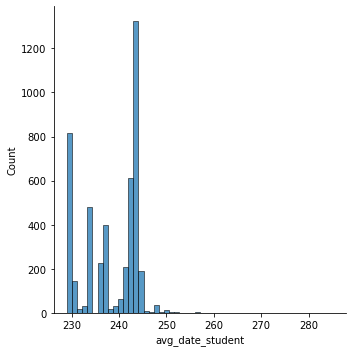

In [87]:
# Visualizing passing time distribution for easier clusters selecting
sns.displot(df_r.avg_date_student)

In [88]:
df_r

,id_student,avg_date_student
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0
...,...,...
4627,2694886,236.0
4628,2694933,230.0
4629,2695608,237.0
4630,2697181,230.0


In [89]:
# Calculate R metric and cut on 2 clusters
# Selecting thresholds based on passing time distribution
df_r['R_category'] = pd.cut(df_r.avg_date_student, bins = [200, 241, 300], labels = [1, 2])

In [90]:
df_r.R_category.value_counts()

1    2425
2    2207
Name: R_category, dtype: int64

In [91]:
df_r.drop(columns = ['avg_date_student'], inplace = True)

In [92]:
# Merge metrics with the master dataframe
df_rfm = pd.merge(df_rfm, df_r, how = 'left', on = ['id_student'])

In [93]:
df_rfm

,id_assessment,id_student,date_submitted,is_banked,score,code_module,id_semester,assessment_type,date,weight,semester_length,date_registration,date_unregistration,exam_passed,completion_ratio,average_date,student_avg_score,M_category,F_category,R_category
0,24290,558914,230,0,32,CCC,2014B,Exam,9999,100,241,-74,0,0,0.89,231.62,34.0,2,3,1
1,24290,559706,234,0,78,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,75.5,1,1,1
2,24290,559770,230,0,54,CCC,2014B,Exam,9999,100,241,-22,0,1,0.89,231.62,54.0,1,1,1
3,24290,560114,230,0,64,CCC,2014B,Exam,9999,100,241,-281,0,1,0.89,231.62,57.5,1,1,1
4,24290,560311,234,0,100,CCC,2014B,Exam,9999,100,241,-28,0,1,0.89,231.62,86.5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,25368,652680,243,0,91,DDD,2014J,Exam,9999,100,262,-144,0,1,0.89,242.79,91.0,1,1,2
4954,25368,652732,249,0,47,DDD,2014J,Exam,9999,100,262,-17,0,1,0.89,242.79,47.0,1,1,2
4955,25368,652965,242,0,87,DDD,2014J,Exam,9999,100,262,-142,0,1,0.89,242.79,87.0,1,1,2
4956,25368,653051,242,0,27,DDD,2014J,Exam,9999,100,262,-60,0,0,0.89,242.79,27.0,2,3,2


In [94]:
# Cleaning the master RFM dataframe for better reading
df_rfm.drop(columns = ['id_assessment', 'is_banked', 'score',
       'code_module', 'id_semester', 'assessment_type', 'date', 'weight',
       'semester_length', 'date_registration', 'date_unregistration',
       'exam_passed', 'completion_ratio', 'average_date'], inplace = True)

In [95]:
# Joining RFM metrics together to complete clusters in RFM analysis
df_rfm = df_rfm.astype({'M_category': 'object', 'R_category': 'string', 'F_category': 'string'})
df_rfm = df_rfm.astype({'M_category': 'string'})

In [96]:
df_rfm.drop_duplicates(subset = 'id_student', inplace = True)

In [97]:
df_rfm['RFM_cluster'] = df_rfm['R_category'] + df_rfm['F_category'] + df_rfm['M_category'] 

In [98]:
df_rfm.head()

,id_student,date_submitted,student_avg_score,M_category,F_category,R_category,RFM_cluster
0,558914,230,34.0,2,3,1,132
1,559706,234,75.5,1,1,1,111
2,559770,230,54.0,1,1,1,111
3,560114,230,57.5,1,1,1,111
4,560311,234,86.5,1,1,1,111


In [99]:
data = df_rfm.groupby('RFM_cluster', as_index = False)\
.agg({'id_student' : 'count'})\
.rename(columns = {'id_student' : 'count'})\
.sort_values(by = 'count')

In [100]:
data

,RFM_cluster,count
9,222,1
4,131,3
8,221,3
10,231,3
3,122,6
2,121,18
7,212,43
1,112,58
11,232,265
5,132,267


<AxesSubplot:xlabel='RFM_cluster', ylabel='count'>

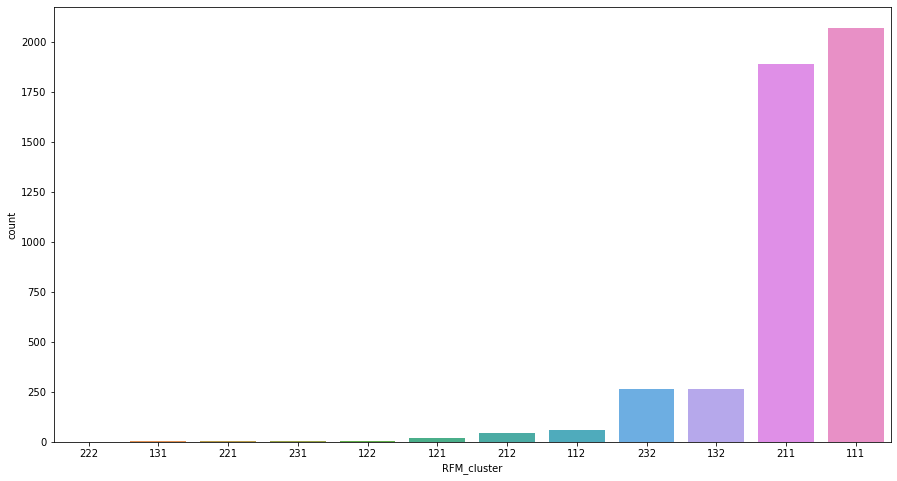

In [101]:
# Visualizing the RFM clusters distribution
plt.figure(figsize=(15,8))
sns.barplot(x="RFM_cluster", y="count", data=data)

Most students are assigned to cluster **111** - the good average exam passing time with the first attempt and the highest score

There are two clusters in the top with students who passed the exam on the first attempt.
It is logical that they scored more than 40 points on average.

The current analysis is not exhaustive, as we have skipped other tests and part of information from the analysis

Also, splitting into clusters in RFM analysis can be done by dividing the data into equal parts, but in essence this does not give us any answers when interpreting the results.